In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def estimar_chi(xx, XX):
    X, Y = XX[:,0], XX[:,1]
    x, y = xx[:,0], xx[:,1]
    
    ecs_x = []
    ecs_y = []
    ax0, ax1, ax2, ax3 = sp.symbols('ax0:4')
    ay0, ay1, ay2, ay3 = sp.symbols('ay0:4')
    for i in range(4):
        ecs_x.append(sp.Eq(x[i], ax0 + ax1*X[i] + ax2*Y[i] + ax3*X[i]*Y[i]))
        ecs_y.append(sp.Eq(y[i], ay0 + ay1*X[i] + ay2*Y[i] + ay3*X[i]*Y[i]))

    solx = sp.solve(ecs_x, [ax0, ax1, ax2, ax3])
    soly = sp.solve(ecs_y, [ay0, ay1, ay2, ay3])

    X, Y = sp.symbols('X Y')
    return sp.Matrix([ solx[ax0] + solx[ax1]*X + solx[ax2]*Y + solx[ax3]*X*Y,
                       soly[ay0] + soly[ay1]*X + soly[ay2]*Y + soly[ay3]*X*Y ])

def dibujar_posini_posfin(xx, XX):
    X, Y = XX[:,0], XX[:,1]
    x, y = xx[:,0], xx[:,1]
    fig, ax = plt.subplots(figsize =(16, 8))
    ax.plot(np.r_[X, X[0]], np.r_[Y, Y[0]], label='original')
    ax.plot(np.r_[x, x[0]], np.r_[y, y[0]], label='deformada')
    ax.set_aspect('equal') 
    ax.legend()
    
    plt.show()
    
def evaluar_chi(chi, npX, npY):
    X, Y = sp.symbols('X Y')
    f = sp.lambdify((X,Y), chi, "numpy")
    xx = np.squeeze(f(npX,npY))
    x, y = xx[0], xx[1]    
    return x, y
    
def dibujar_chi(chi, XX, ejes): 
    X, Y = XX[:,0], XX[:,1]
    x, y = evaluar_chi(chi, X, Y)
    
    # Se dibuja la posición original y la actual
    fig, ax = plt.subplots(figsize =(16, 8))
    ax.plot(np.r_[X, X[0]], np.r_[Y, Y[0]], label='original')    
    ax.plot(np.r_[x, x[0]], np.r_[y, y[0]], label='actual')
    ax.set_aspect('equal') 
    ax.legend()
    
    #xmin, xmax, ymin, ymax = ax.axis()
    xmin, xmax, ymin, ymax = ejes
    XX = np.linspace(xmin, xmax, 20)
    YY = np.linspace(ymin, ymax, 20)
    X, Y = np.meshgrid(XX, YY)
    x, y = evaluar_chi(chi, X, Y)
    ax.quiver(X, Y, x-X, y-Y) # angles='xy', scale_units='xy', scale=1)    
    
    plt.show()
    
    
def dibujar_chi_con_contorno(chi, XX, ejes, vec_prop=True):
    X, Y = sp.symbols('X Y')
    F = np.array(chi.jacobian([X,Y])).astype(np.float64)
    
    X, Y = XX[:,0], XX[:,1]
    x, y = evaluar_chi(chi, X, Y)
    
    # Se dibuja la posición original y la actual
    fig, ax = plt.subplots(figsize =(16, 8))
    ax.plot(np.r_[X, X[0]], np.r_[Y, Y[0]], label='original')    
    ax.plot(np.r_[x, x[0]], np.r_[y, y[0]], label='actual')
    ax.set_aspect('equal') 
    ax.legend()
    
    #xmin, xmax, ymin, ymax = ax.axis()
    xmin, xmax, ymin, ymax = ejes
    XX = np.linspace(xmin, xmax, 20)
    YY = np.linspace(ymin, ymax, 20)
    X, Y = np.meshgrid(XX, YY)
    x, y = evaluar_chi(chi, X, Y)
    ax.quiver(X, Y, x-X, y-Y) # angles='xy', scale_units='xy', scale=1)    
       
    xT_invF_X = np.zeros_like(X)
    invF = np.linalg.inv(F)
    m, n = X.shape
    for i in range(m):
        for j in range(n):
            mix = np.array([X[i,j], Y[i,j]])
            xT_invF_X[i,j] = mix.T@invF@mix
    ax.contour(X,Y,xT_invF_X, 30)
    
    if vec_prop:
        valp, vecp = np.linalg.eig(invF)
        ax.quiver(0, 0, vecp[0,0], vecp[1,0], angles='xy', scale_units='xy', scale=valp[0]) 
        ax.quiver(0, 0, vecp[0,1], vecp[1,1], angles='xy', scale_units='xy', scale=valp[1]) 
    
    plt.show()    

In [3]:
X, Y = sp.symbols('X Y')

XX = np.array([(-1,-1), (1,-1), (1,1),  (-1,1)])   # posición inicial (referencial)
xx = np.array([( 1, 2), (2, 5), (2, 6), ( 1,4)])   # posición actual  (espacial)

Se estima la función $\boldsymbol{x} = \boldsymbol{\chi}(\boldsymbol{X})$:

In [4]:
chi = estimar_chi(xx, XX)
chi

Matrix([
[                    X/2 + 3/2],
[-X*Y/4 + 5*X/4 + 3*Y/4 + 17/4]])

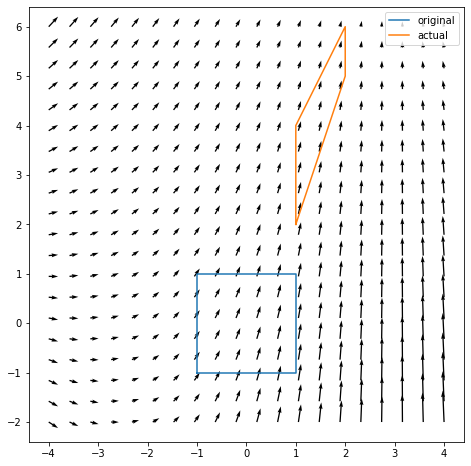

In [5]:
dibujar_chi(chi, XX, [-4, 4, -2, 6])

Se calcula el gradiente de deformación $\boldsymbol{F}$ como el gradiente del campo vectorial de desplazamientos $\boldsymbol{\chi}$:

In [6]:
F1 = chi.jacobian([X,Y])
F1

Matrix([
[      1/2,         0],
[5/4 - Y/4, 3/4 - X/4]])

Se calcula el vector de desplazamientos $\boldsymbol{u} = \boldsymbol{x} - \boldsymbol{X}$

In [7]:
u = chi - sp.Matrix([X,Y])
u

Matrix([
[                  3/2 - X/2],
[-X*Y/4 + 5*X/4 - Y/4 + 17/4]])

Se calcula el gradiente de deformación $\boldsymbol{F}$ como $\boldsymbol{F} = \boldsymbol{I} + \frac{\partial\boldsymbol{u}}{\partial\boldsymbol{X}}$:

In [8]:
I = sp.eye(2)
F2 = I + u.jacobian([X,Y])
F2

Matrix([
[      1/2,         0],
[5/4 - Y/4, 3/4 - X/4]])

# Desplazamiento rígido

In [9]:
chi = sp.Matrix([[X + 5], 
                 [Y + 2]])
F = chi.jacobian([X,Y])
F

Matrix([
[1, 0],
[0, 1]])

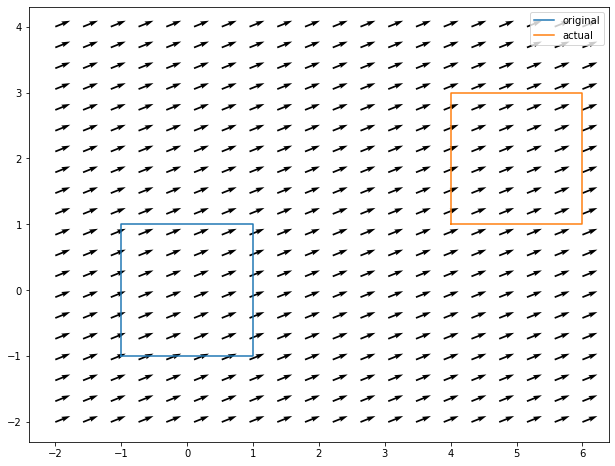

In [10]:
dibujar_chi(chi, XX, [-2, 6, -2, 4])

# Rotación rígida

In [11]:
t = np.deg2rad(15)
chi = sp.Matrix([[ X*sp.cos(t) - Y*sp.sin(t) ], 
                 [ X*sp.sin(t) + Y*sp.cos(t) ]]) 
F = chi.jacobian([X,Y])
F

Matrix([
[0.965925826289068, -0.258819045102521],
[0.258819045102521,  0.965925826289068]])

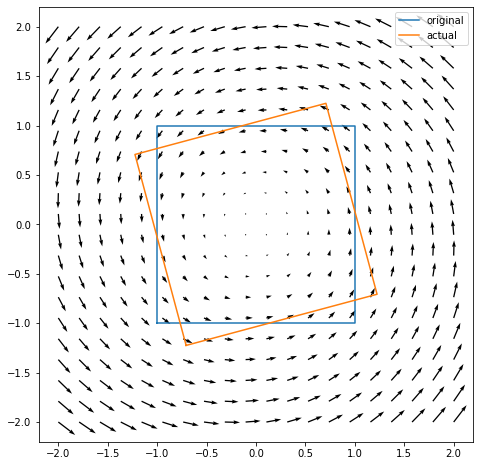

In [12]:
dibujar_chi(chi, XX, [-2, 2, -2, 2])

# Estiramiento en ambas direcciones

In [13]:
chi = sp.Matrix([[2*X + 0*Y], 
                 [0*X + 3*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[2, 0],
[0, 3]])

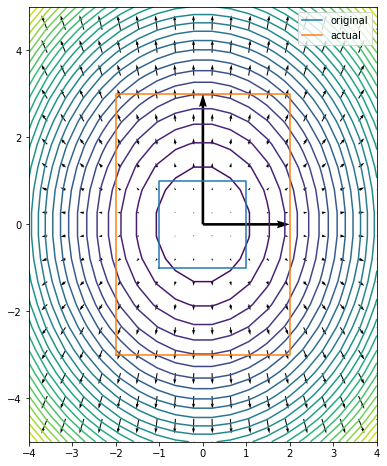

In [14]:
dibujar_chi_con_contorno(chi, XX, [-4, 4, -5, 5])

# Deformación angular (con rotación)

In [15]:
chi = sp.Matrix([[1.0*X + 0.0*Y], 
                 [0.5*X + 1.0*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0,   0],
[0.5, 1.0]])

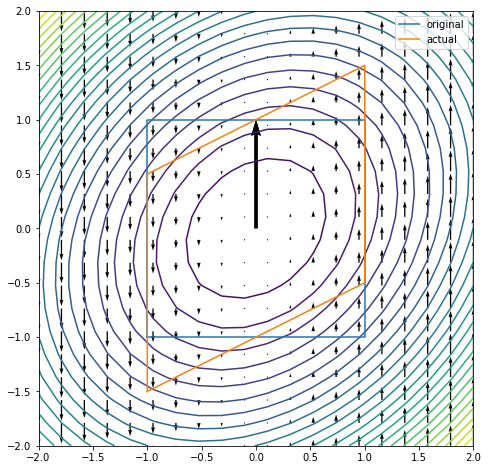

In [16]:
dibujar_chi_con_contorno(chi, XX, [-2, 2, -2, 2])

# Deformación angular pura

In [17]:
chi = sp.Matrix([[1.0*X + 0.5*Y], 
                 [0.5*X + 1.0*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0, 0.5],
[0.5, 1.0]])

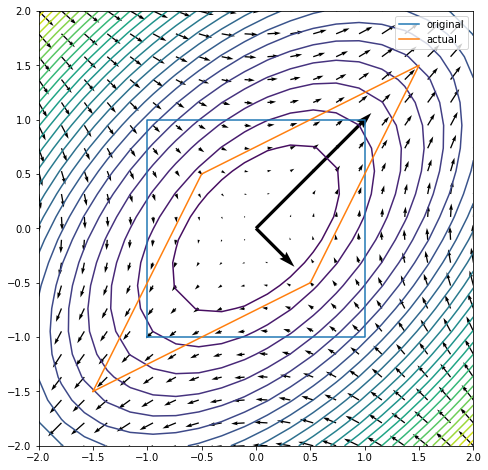

In [18]:
dibujar_chi_con_contorno(chi, XX, [-2, 2, -2, 2])

# Deformaciones generales

In [19]:
chi = sp.Matrix([[1.0*X - 0.675*Y], 
                 [0.3*X + 0.650*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0, -0.675],
[0.3,   0.65]])

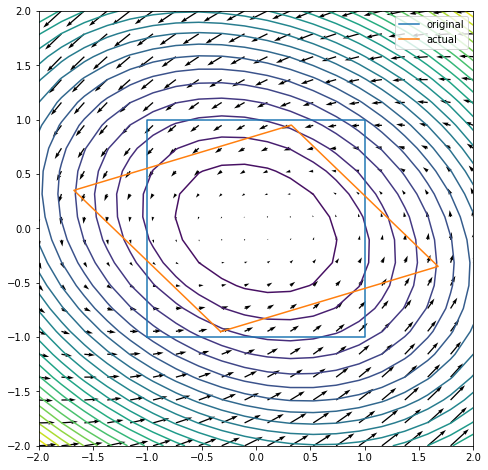

In [20]:
dibujar_chi_con_contorno(chi, XX, [-2, 2, -2, 2], vec_prop=False)

# Descomposición polar

In [21]:
from scipy.linalg import polar

npF = np.array(F).astype(np.float64)
R1, U = polar(npF, 'right')  # F = R*U
R2, v = polar(npF, 'left')   # F = v*R

In [22]:
chiU = sp.Matrix(U) *sp.Matrix([X,Y])
chiR = sp.Matrix(R1)*sp.Matrix([X,Y])
chiv = sp.Matrix(v) *sp.Matrix([X,Y])

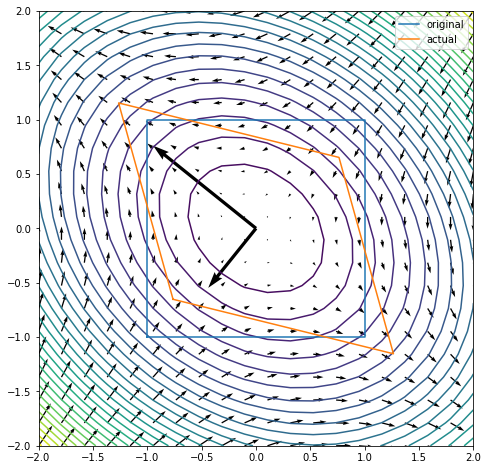

array([[ 1.01354532, -0.25045135],
       [-0.25045135,  0.90299453]])

In [23]:
dibujar_chi_con_contorno(chiU, XX, [-2, 2, -2, 2])
U

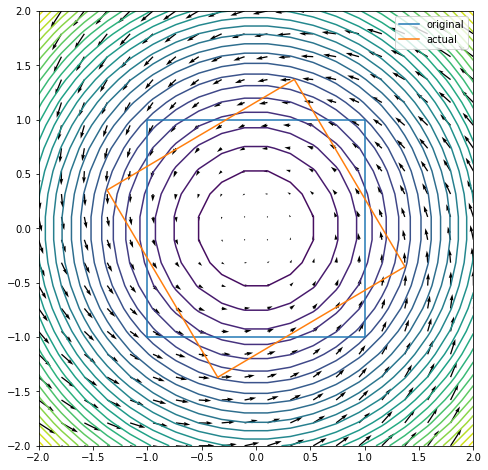

array([[ 0.86092653, -0.50872931],
       [ 0.50872931,  0.86092653]])

In [24]:
dibujar_chi_con_contorno(chiR, XX, [-2, 2, -2, 2], vec_prop=False)
R1

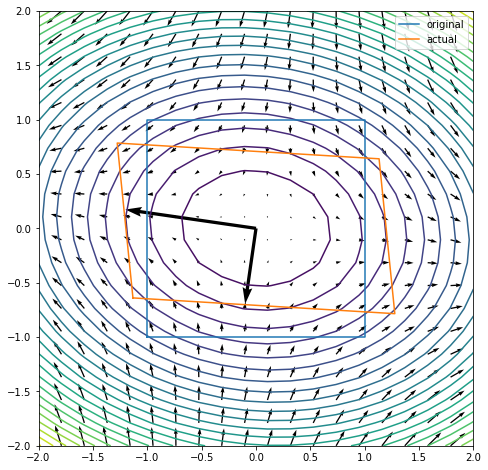

array([[ 1.20431881, -0.07239609],
       [-0.07239609,  0.71222104]])

In [25]:
dibujar_chi_con_contorno(chiv, XX, [-2, 2, -2, 2])
v